In [1]:
import os
import json
import sys
import glob
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# import tensorflow as tf
import torch

# from pycaret.clustering import *

from bertopic import BERTopic
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sentence_transformers import SentenceTransformer, util

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# understand the distribution of songs attributes
songs_set = pd.read_csv('../songsdata/cleaned_data/cleaned_songs.csv') ; songs_set.head(2)

,artist,title,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,duration,time_signature,lyrics,genius_id,annotation,lyrics_list,line_len,song_len
0,A Few Good Men,Tonite,0.615,0.673,5.0,-8.501,0.0,0.1150,0.0429,0.0,...,0.831,178.124,254360.0,4.0,Tonite LyricsYou know I really want to love yo...,1382268.0,[],['Tonite LyricsYou know I really want to love ...,6.666667,66
1,A Few Good Men,Have I Never,0.717,0.377,4.0,-8.680,1.0,0.0288,0.2820,0.0,...,0.161,120.036,336533.0,4.0,Have I Never LyricsHave I never told you I lov...,1187594.0,[],['Have I Never LyricsHave I never told you I l...,8.196078,51


In [3]:
songs_set.columns

Index(['artist', 'title', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration', 'time_signature', 'lyrics', 'genius_id',
       'annotation', 'lyrics_list', 'line_len', 'song_len'],
      dtype='object')

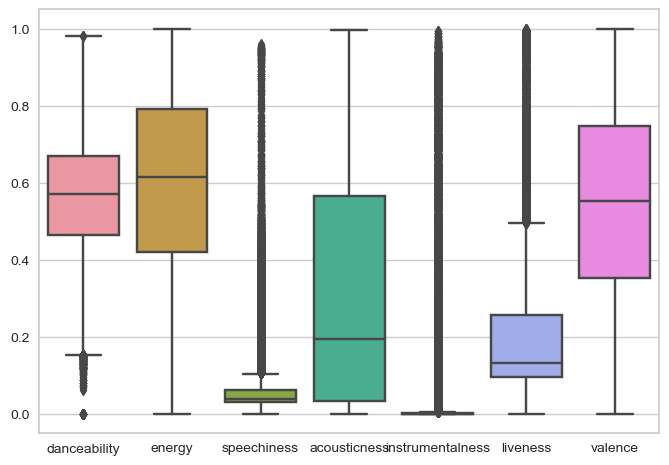

In [4]:
sns.boxplot(data=songs_set[['danceability', 'energy', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence']])
plt.show()

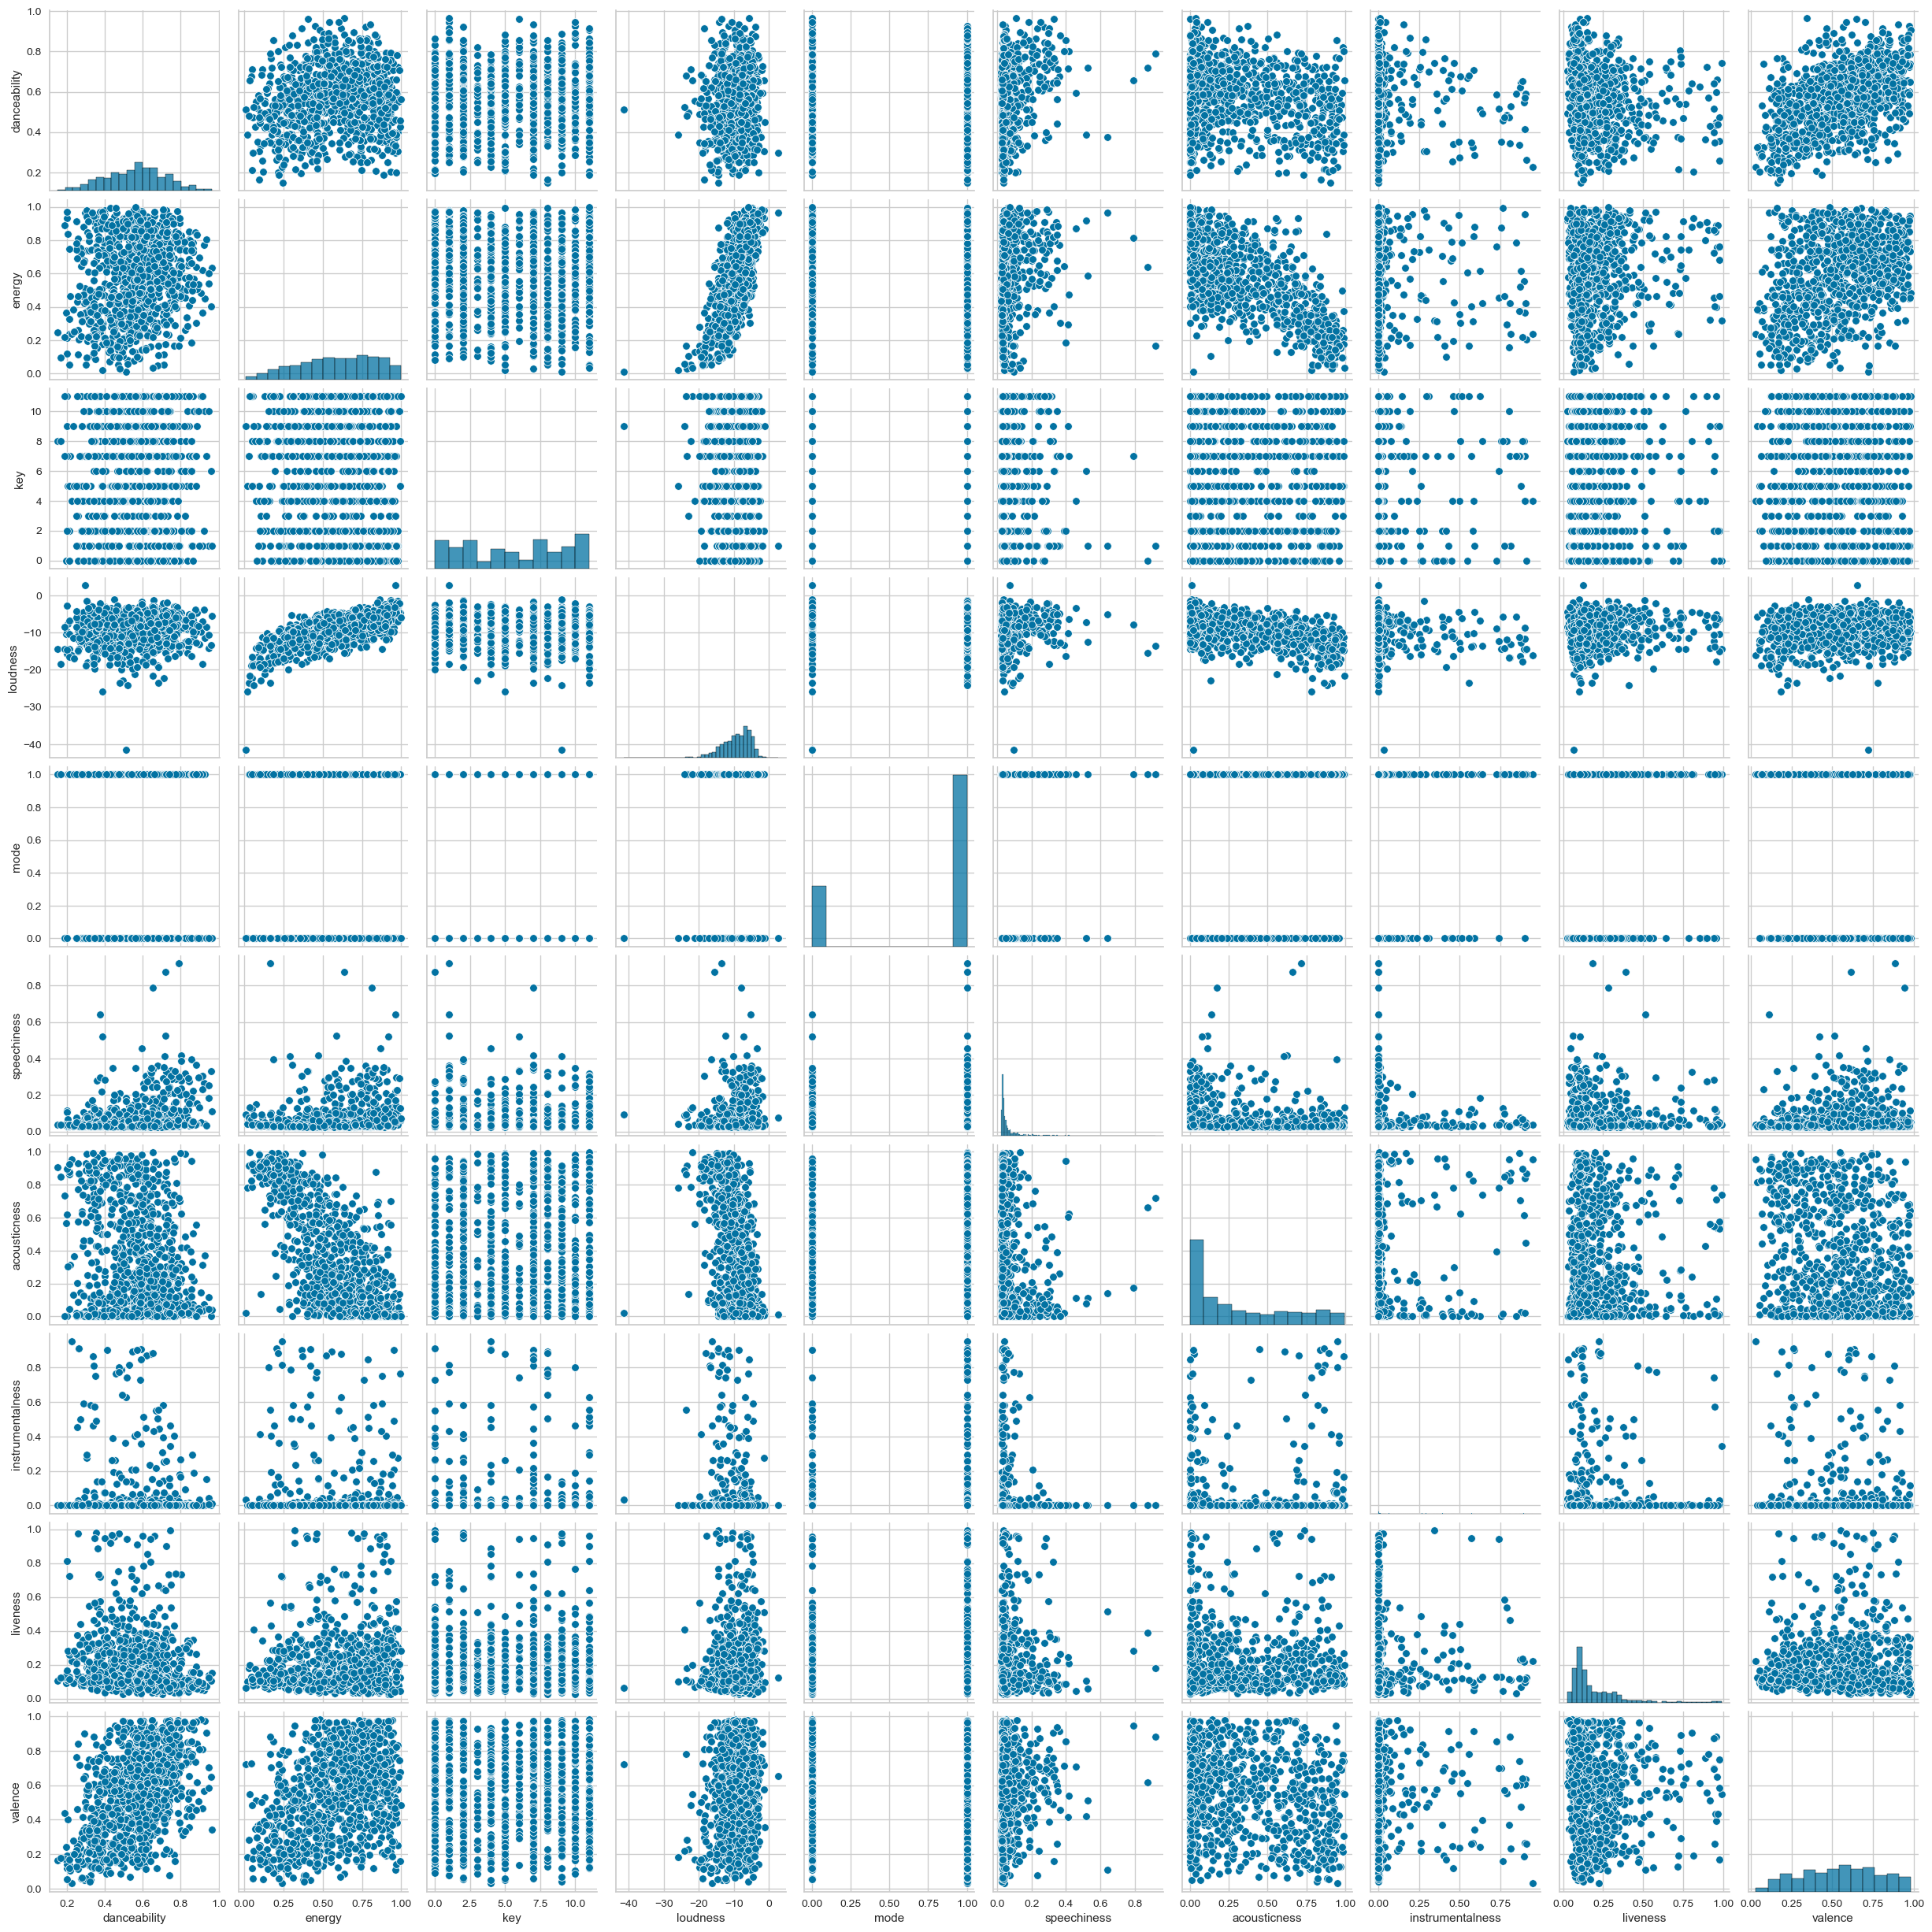

In [5]:
# getting the songs attrbute pairplot
# pairplot will take a lot of time to run with large data sets, so we are going to use only 1000 samples
sample_songs_set = songs_set.sample(n=1000, random_state=42)
sns.pairplot(sample_songs_set[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence']])
plt.show()

In [6]:
# transform lyrics to vector embedding
# get the vector embedding of the sampling 1000 dataset from the 100k songs data >> preprocess_lyrics.ipynb
with open('../pickle_objects/embeddings_indices.pickle', 'rb') as f:
    embeddings, arr_song_idx, arr_lyrics_idx = pickle.load(f)

with open('../pickle_objects/song_lyrics_set.pickle', 'rb') as f:
    songs_set, lyrics_set = pickle.load(f)
# embeddings, arr_song_idx, arr_lyrics_idx, songs_set, lyrics_set

In [7]:
embeddings.shape

(53882, 768)

In [8]:
# getting songs index to be trained with bertopic
songs_idx = sorted(list(set(arr_song_idx)))

In [9]:
# getting songs in the index
sample_songs_set = songs_set.loc[songs_set.index.isin(songs_idx)]
lyrics = sample_songs_set['lyrics'].tolist(); lyrics

In [10]:
embeddings_df = pd.DataFrame(embeddings); embeddings_df.shape
embeddings_df = embeddings_df.dropna(); embeddings_df.shape 
embeddings = embeddings_df.to_numpy(); embeddings.shape


(53882, 768)

In [11]:
# embeddings = embeddings[~np.isnan(embeddings).any(axis=1), :]; embeddings

In [24]:
topic_model = BERTopic(language="multilingual", embedding_model="all-distilroberta-v1")
topics, probs = topic_model.fit_transform(lyrics)

In [27]:
topic_model.get_topic_info()

,Topic,Count,Name
0,0,972,0_you_the_and_to
1,1,28,1_10_11_12_ep


In [28]:
topic_model.get_topic(0)

[('you', 0.11203019087020084),
 ('the', 0.09967498921079707),
 ('and', 0.07447147224247724),
 ('to', 0.07228465388217457),
 ('me', 0.06192280281288423),
 ('it', 0.06129157070029479),
 ('my', 0.05156994614956466),
 ('in', 0.049286731567718414),
 ('that', 0.04464756647687398),
 ('of', 0.0410614962280774)]

In [29]:
topic_model.get_topic(1)

[('10', 0.1552382054112098),
 ('11', 0.15395852549369304),
 ('12', 0.14070014912936737),
 ('ep', 0.09752522861900101),
 ('13', 0.09703546073189162),
 ('the', 0.09489700588178565),
 ('14', 0.08207131029724153),
 ('15', 0.06933839980479624),
 ('16', 0.058828526318545356),
 ('17', 0.04473201485904463)]

In [30]:
topic_model.visualize_topics()

ValueError: zero-size array to reduction operation maximum which has no identity

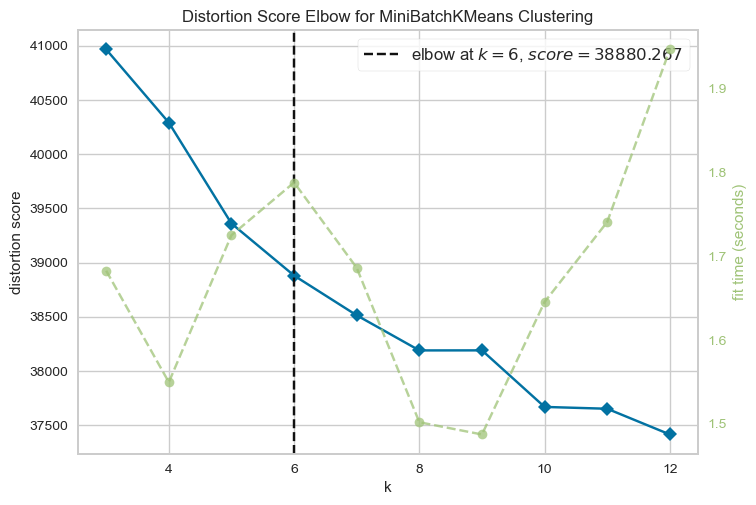

<AxesSubplot:title={'center':'Distortion Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
X = embeddings
model = MiniBatchKMeans(init='k-means++', max_iter=300, random_state=42, batch_size=2048)
visualizer = KElbowVisualizer(model, k=(3,13))
visualizer.fit(X)
visualizer.show()

In [32]:
kmeans = MiniBatchKMeans(n_clusters=6, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
labels = kmeans.fit_predict(X)
embeddings_df['label'] = labels; embeddings_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,0.019325,0.002138,0.015113,-0.008251,0.077507,-0.005123,-0.015538,0.043546,-0.046522,0.053172,...,0.048817,0.002366,0.048622,-0.010332,-0.015972,0.022328,-0.003719,-0.039871,-0.010719,4
1,-0.002085,-0.003281,-0.015625,-0.019065,0.089184,0.007907,0.012572,-0.002649,-0.001498,0.007763,...,0.022597,0.049541,0.030380,-0.001679,0.044922,0.023056,-0.077226,-0.038105,-0.016849,2
2,-0.020927,0.016403,0.014267,-0.033494,0.047279,0.027163,0.053915,0.019717,0.018056,-0.029822,...,-0.021955,-0.027124,0.036455,0.005121,-0.021783,0.029638,-0.011548,-0.005115,0.018169,2


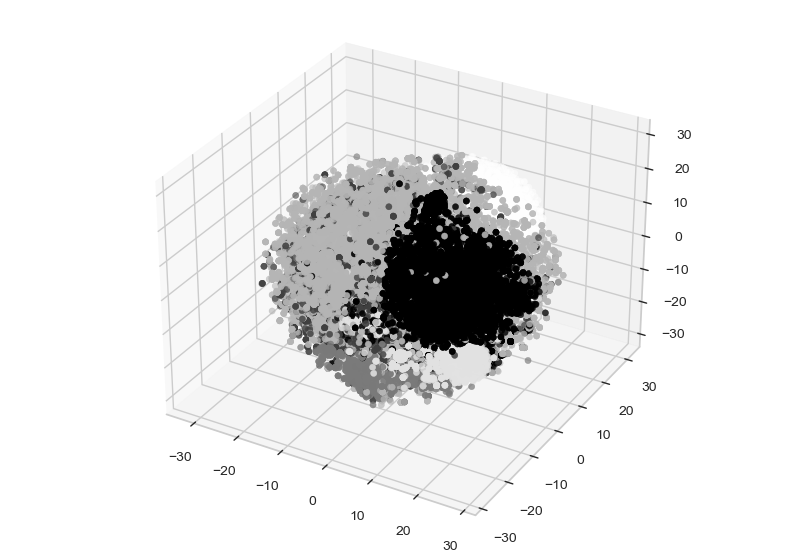

In [33]:
# try 3-D representation with t_SNE
from wsgiref.headers import tspecials
from mpl_toolkits.mplot3d import Axes3D
# to create interactive 3D plot
%matplotlib widget

# Initialize t-SNE with 3 components for 3-dimensional plot
tsne = TSNE(n_components = 3, init = 'random', random_state = 0, perplexity = 75)

tsne_df = pd.DataFrame(tsne.fit_transform(X), columns = ['component1','component2', 'component3'])
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tsne_df['component1'], tsne_df['component2'], tsne_df['component3'], c=labels)

plt.show()

In [ ]:
# what you have is lyrics embedding of 50k lines of text and songs index
# you want to create a 3D visualization of the embeddings with query
# reduce dimensions of embeddings >> create PCA functions to reduce embeddings
# get TF-IDF from the arr_lyrics_idx


In [ ]:
# cluster visualization with text and valence
